## 📊 Diabetic Retinopathy Detection Using CNNs

This project implements a **Convolutional Neural Network (CNN)** to detect **diabetic retinopathy (DR)** from fundus retinal images. DR is a leading cause of blindness, and early detection is critical for effective intervention. Using a real-world dataset from Kaggle (APTOS 2019), I built a binary classifier to predict whether a patient should be referred for treatment.

#### 🔍 Key Highlights:
- **End-to-End Pipeline**: Designed and executed a complete ML pipeline from data ingestion to model evaluation using TensorFlow/Keras.
- **CNN Architecture**: Constructed a custom convolutional model for binary classification of DR referral status, distinguishing between non-referral (No/Mild DR) and referral (Moderate/Severe/Proliferative DR).
- **Data Augmentation & Regularization**: Applied techniques such as image flipping, rotation, zoom, and dropout to mitigate overfitting and improve model generalization.
- **Hyperparameter Tuning**: Leveraged Keras Tuner (Random Search and Hyperband) to optimize model depth, filter sizes, dropout rates, and learning rates.
- **Model Evaluation**: Assessed model performance using accuracy, confusion matrices, and validation metrics, while monitoring for signs of overfitting.
- **Ethical Framing**: Focused on practical healthcare impact—reducing the burden on clinicians by automating referral recommendations in under-resourced areas.

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

This project uses a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)) to **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

---
### Step 1: Import libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# images
from PIL import Image
import os

# tuners
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import Hyperband

# FILL IN CODE HERE #
IMAGE_PATH = 'CNN_images/' # replace with your path
LABEL_PATH = 'cnn_labels.csv' # replace with your path

---
### Step 2: Data ingestion

The dataset images utilize fundus photography (photographs of the rear of the eye) taken by Aravind technicians traveling to rural areas.


Then, the images are reviewed by highly trained doctors or clinicians who provide a diagnosis. The image labels correspond to a diagnosis rating based on severity:
- 0 - No DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferative DR

Load the 2D images and their corresponding labels.

``labels``

In [2]:
labels = pd.read_csv(LABEL_PATH)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


In [3]:
type(labels)

pandas.core.frame.DataFrame

There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)

``images``

In [4]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

---
### Step 3: Exploratory Data Analysis (EDA)

It's acceptable to check the class distribution before splitting the data because visualizing the distribution does not provide the model with information about the relationships between features and labels. We are not using this information for feature engineering. 

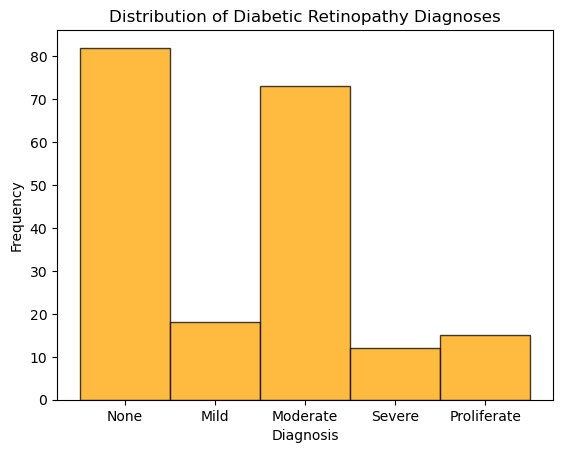

In [5]:
# Create histogram
plt.hist(labels['diagnosis'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], color="orange", edgecolor="black", alpha=0.75)

# Formatting
plt.xlabel("Diagnosis")
plt.ylabel("Frequency")
plt.title("Distribution of Diabetic Retinopathy Diagnoses")

# Custom x-ticks
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["None", "Mild", "Moderate", "Severe", "Proliferate"])

plt.show()

The data has a severe class imbalance, with ~80 instances of None and Moderate DR, and <20 instances of Mild, Severe, and Proliferate DR. 

Let's take a look at a few of the images to understand our dataset a bit better.

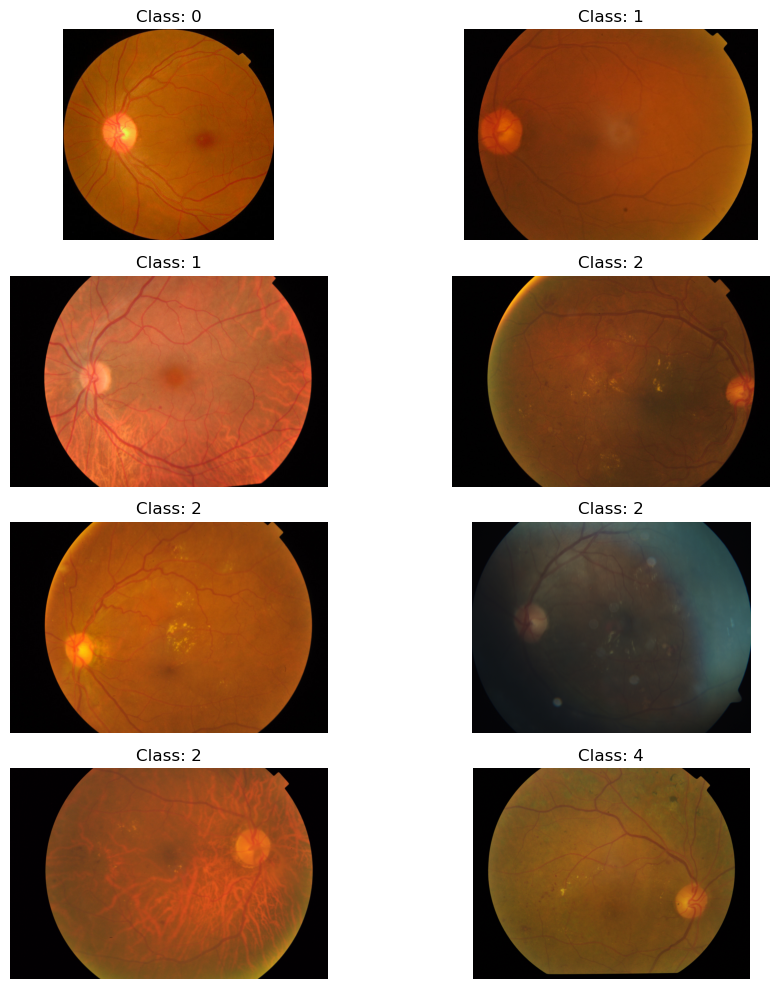

In [6]:
# first let's just look at the first 8 images
sample_8 = labels[:8].sort_values(by='diagnosis').reset_index(drop=True)
# set up fig
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,10))
axes = axes.flatten() # for looping
# loop and plot
for i,row in sample_8.iterrows():
    image_path = os.path.join(IMAGE_PATH, row['id_code'] +'.png') # build path to each image
    img = Image.open(image_path)  # load image
    axes[i].imshow(img) # display image
    axes[i].set_title(f"Class: {row['diagnosis']}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


Obervations:
- The images are different sizes.
- The images are of different quality - some seem to be clearer than others.
- The images are of different orientations, with 5 seeming to have brighter spots on the left, and three having brighter spots on the right.
- Most of the eyes in the images are orange-ish, but one is blue, appearing distincly different. 
- Brightness level varies a great deal between images.

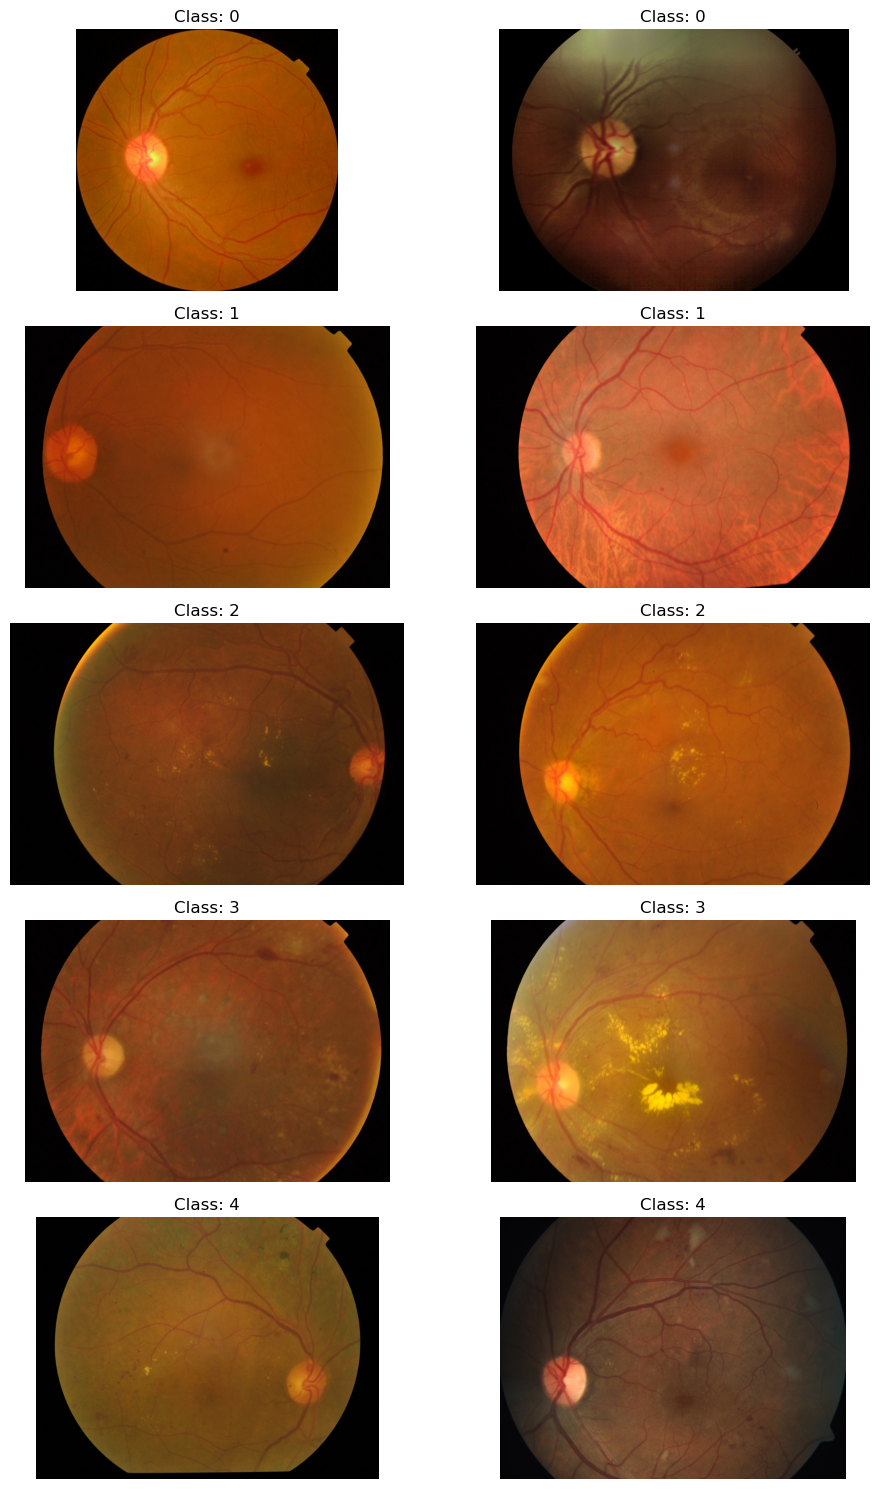

In [7]:
# i also want to look at 10 images - the first two of each class
sample = labels.groupby('diagnosis').head(2).sort_values(by='diagnosis').reset_index(drop=True)
# set up fig
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
axes = axes.flatten() # for looping
# loop through sample and plot each image
for i, row in sample.iterrows():
    image_path = os.path.join(IMAGE_PATH, row['id_code'] +'.png') # build path to each image
    img = Image.open(image_path)  # load image
    axes[i].imshow(img) # display image
    axes[i].set_title(f"Class: {row['diagnosis']}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

---
### Step 4: Data preprocessing

First, we will correct for class imbalance. Note that imbalanced data is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

In [8]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [9]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [10]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


Next, we will create train, validation, and test datasets by:

1. shuffling images and labels before splitting the data

2. using a (0.6,0.2,0.2)train/validation/test set split

3. performing image transformation and augmentation, as follows:
    * Applied on training set only:
         - creating additional copies (augmentations) of the training images by flipping left right each image
         - concatenating the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. We can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [ ]:
def preprocess_data_part2(images, labels, splits):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)   
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    # create list of indices
    indices = []
    for i in range(labels.shape[0]):
        indices.append(i)

    # shuffle indices
    shuffled_indices = np.random.permutation(indices)

    # create shuffled datasets
    labels = labels[shuffled_indices]
    images = images[shuffled_indices]
    
    # create data splits (training, val, and test sets)
    # initial split into train and temporary dfs
    X_train, X_not_train, y_train, y_not_train = train_test_split(
        images, labels, test_size=splits[1]+splits[2], random_state=1234
    )

    # split temp df into val and test dfs
    X_val, X_test, y_val, y_test = train_test_split(
        X_not_train, y_not_train, test_size=splits[2]/(splits[1] + splits[2]), random_state=1234
    )

    # split notes for future me
    # val_ratio = val_frac / (val_frac + test_frac)
    # test_ratio = test_frac / (val_frac + test_frac)
    
    # image augmentation (random flip) on training data
    X_train_augm = []
    for img in X_train:
        # random flip
        X_augm = tf.image.random_flip_left_right(img)
        X_train_augm.append(X_augm)
    X_train_augm = np.array(X_train_augm)

    # concatenate original X_train and augmented X_train_augm data
    X_train = np.concatenate((X_train, X_train_augm),axis=0)

    # concatenate y_train (note the label is preserved)
    y_train = tf.concat([y_train, y_train], axis=0)


    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale training, val, and test images by dividing each pixel by 255.0 
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. We are interested in exploring binary classification of 'no refer' and 'refer'.

The implementation of the CNN classifier follows these guidelines:

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. The model is built and compiled using the Adam optimizer and a learning_rate = 0.1. 
8. The model trains on (X_train, y_train) data for 20 epochs, while also implementing early stopping 

In [ ]:
# build helper function for plotting results
def plot_loss_pretty(history):
    # Ensure we're accessing history correctly from Keras History object
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Use Seaborn theme for a polished look
    sns.set_theme(style="darkgrid", palette="muted")

    plt.figure(figsize=(7,5))  # Slightly wider for readability

    # Title with enhanced font
    plt.title('Classification Model Loss', fontsize=14, fontweight='bold', color='#707258') # oak moss

    # Labels with larger font
    plt.xlabel('Epochs', fontsize=12, color='#5A5D46') # secret garden
    plt.ylabel('Log Loss', fontsize=12, color='#5A5D46')

    num_epochs = len(loss)

    # Dynamically determine tick interval
    if num_epochs <= 10:
        tick_interval = 1
    elif num_epochs <= 50:
        tick_interval = 5
    else:
        tick_interval = 10  # Adjust for larger epoch sizes

    plt.xticks(np.arange(1, num_epochs + 1, step=tick_interval), fontsize=10, color='#707258')
    plt.yticks(fontsize=10, color='#707258')

    # Define colors for clarity
    train_color = '#98694D'  # terra cotta
    val_color = '#707258'    # oak moss

    # Plot loss curves with smooth lines and transparency
    plt.plot(loss, label='Training Loss', marker='o', markersize=5, linestyle='-', linewidth=2, color=train_color, alpha=0.8)
    plt.plot(val_loss, label='Validation Loss', marker='s', markersize=5, linestyle='--', linewidth=2, color=val_color, alpha=0.8)

    # Add a caption below the plot
    # plt.figtext(0.5, -0.12, 'enter caption here', 
    #             ha='center', fontsize=10, alpha=0.7, color='#B5B7A1')

    # Move legend to a cleaner spot
    plt.legend(loc='upper right', fontsize=10, frameon=True, edgecolor='#707258')

    # Show plot
    plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_1 (Dropout)                │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 - 1s - 183ms/step - accuracy: 0.4688 - loss: 831.0327 - val_accuracy: 0.3750 - val_loss: 0.7288
Epoch 2/20
6/6 - 1s - 122ms/step - accuracy: 0.5312 - loss: 0.6951 - val_accuracy: 0.3750 - val_loss: 0.7434
Epoch 3/20
6/6 - 1s - 123ms/step - accuracy: 0.5312 - loss: 0.6956 - val_accuracy: 0.3750 - val_loss: 0.7425
Epoch 4/20
6/6 - 1s - 127ms/step - accuracy: 0.5312 - loss: 0.6937 - val_accuracy: 0.3750 - val_loss: 0.7320
Epoch 5/20
6/6 - 1s - 134ms/step - accuracy: 0.5312 - loss: 0.6915 - val_accuracy: 0.3750 - val_loss: 0.7199
Epoch 6/20
6/6 - 1s - 129ms/step - accuracy: 0.5312 - loss: 0.6907 - val_accuracy: 0.3750 - val_loss: 0.7106
Epoch 7/20
6/6 - 1s - 129ms/step - accuracy: 0.5312 - loss: 0.6909 - val_accuracy: 0.3750 - val_loss: 0.7058
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


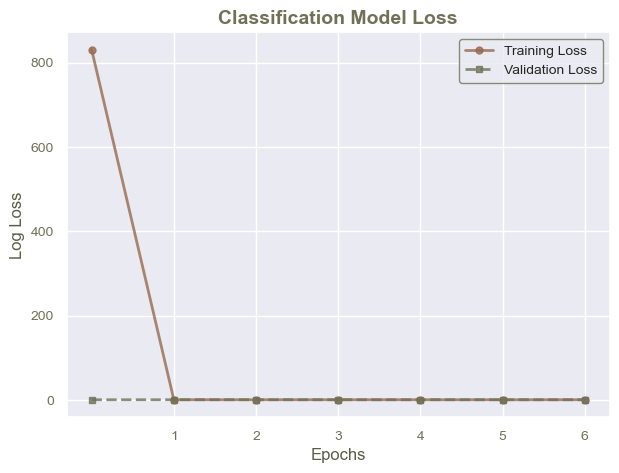

================ MODEL ACCURACY ** DURING ** TRAINING ================
Best epoch (as determined by highest training accuracy): 1 
Train Accuracy for epoch 1: 0.4688
Validation Accuracy for epoch 1: 0.3750


In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy', # 'accuracy' monitors training accuracy // 'val_accuracy' monitors validation accuracy
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4,4),
    strides=(1,1), # step size of the filter
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu' 
))

# add max pooling layer 
model_tf.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2,2), # filter size; for each 2×2 region of the feature map, look at all 4 values and keep max (chatgpt)
    name='pool_1'
))

# add dropout layer
model_tf.add(tf.keras.layers.Dropout(
    rate=0.3, # Float between 0 and 1. Fraction of the input units to drop. (chatgpt)
    name='drop_1'
))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

# add the classification layer
model_tf.add(tf.keras.layers.Dense(
    units=1, # binary output - not 2 bc in binary classification, you're only trying to predict one thing:
                # What's the probability this input belongs to class 1?
                # With that, you automatically know the probability of class 0 is 1 - p. (chatgpt)
    activation='sigmoid' # sigmoid for binary, softmax for multiclass
))

    # The last layer of the model is the classification head.
    # The number of units (also called neurons) in your final classification layer depends on number of output classes (chatgpt)

# build and compile model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model_tf summary
model_tf.summary()

# train model_tf on (X_train, y_train) data
history = model_tf.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=2, # 0 = silent, 1 = progress bar, 2 = one line per epoch (chatgpt)
    validation_data=(X_val,y_val),
    callbacks=[early_stopping]
)

# plot loss curves
plot_loss_pretty(history)

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
print("================ MODEL ACCURACY ** DURING ** TRAINING ================")
best_epoch = np.argmax(history.history['val_accuracy'])
best_train_acc = history.history['accuracy'][best_epoch]
best_val_acc = history.history['val_accuracy'][best_epoch]
print(f"""Best epoch (as determined by highest training accuracy): {best_epoch + 1} 
Train Accuracy for epoch {best_epoch + 1}: {best_train_acc:.4f}
Validation Accuracy for epoch {best_epoch + 1}: {best_val_acc:.4f}""") # best_epoch + 1 bc epochs start at 1 (not 0)


In [ ]:
# build helper function to evaluate model performance
def eval_accuracy(
        model,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test=None,
        y_test=None,
        accuracy_threshold=0.05,
        model_name="model"
):
    """
    Evaluates and prints training, validation, and (optionally) test accuracy for a given classification model.

    The function also analyzes the gap between training and validation/test accuracy to assess model generalization,
    and provides interpretive messages regarding overfitting or underfitting behavior based on a user-defined threshold.

    Args:
        model: Trained classification model with a .predict() method (e.g., scikit-learn or Keras classifier).
        X_train: Feature matrix for training data.
        y_train: True labels for training data.
        X_val: Feature matrix for validation data.
        y_val: True labels for validation data.
        X_test (optional): Feature matrix for test data. Defaults to None.
        y_test (optional): True labels for test data. Defaults to None.
        accuracy_threshold (float): Threshold (in decimal form) for acceptable accuracy gap between training and validation/test sets.

    Returns:
        None. Prints accuracy results and interpretive generalization analysis.
    """
    # answer param question
    total_params = model.count_params()
    print("================ NUMBER OF PARAMETERS ================")
    print(f'How many parameters does {model_name} have?')
    print(f'{model_name} has {total_params} parameters')

    # compute accuracy on training data
    training_loss, training_accuracy = model.evaluate(X_train, y_train, verbose=0)

    # compute accuracy on validation data
    validation_loss, validation_accuracy = model.evaluate(X_val, y_val, verbose=0)

    # display training/validation accuracy
    print('')
    print("================ ACCURACY RESULTS ** AFTER ** TRAINING ================")
    print(f'Training Accuracy: {training_accuracy:.4f}')
    print(f'Validation Accuracy: {validation_accuracy:.4f}')

    # compute accuracy on test data
    if X_test is not None and y_test is not None:
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

        # display training/validation/test accuracy
        print(f'Test Accuracy: {test_accuracy:.4f}')

    # compute accuracy difference(s)
    train_val_acc_diff = round(abs(training_accuracy-validation_accuracy),4)
    print('')
    print("================ ACCURACY GAP ================")
    print(f'There is a {round(train_val_acc_diff*100,2)}% gap between training and validation accuracy.')

    if X_test is not None and y_test is not None:
        train_test_acc_diff = round(abs(training_accuracy-test_accuracy),4)
        print(f'There is a {train_test_acc_diff*100}% gap between training and testing accuracy.')
        print('')
        print("================ GENERALIZABILITY ANALYSIS ================")
        if train_test_acc_diff < accuracy_threshold:
            print(f'The model demonstrates strong generalization capabilities because test accuracy is very close to training accuracy.')
            print(f'This suggests that the model is effectively learning patterns that generalize well to unseen data.')
        elif train_test_acc_diff > accuracy_threshold and training_accuracy > test_accuracy:
            print(f'This gap is larger than {accuracy_threshold*100}%, indicating that the model does not generalize well to new data.')
            print(f'''Since the training accuracy is higher than the test accuracy, the model is likely overfitting — 
memorizing noise and specific patterns in the training data rather than learning the underlying relationships 
that generalize well to new data.''')
        else: # train_test_acc_diff > accuracy_threshold and training_accuracy < test_accuracy
            if train_test_acc_diff >= 0.1:
                print(f'''Due to the large gap between training and test accuracy, and given that test accuracy is higher, the model is likely underfitting. 
Recommendation: check for data leakage and consider increasing model complexity in order to capture relationships better during training.''')
            else: # train_test_acc_diff < 0.1 and train_test_acc_diff > threshold:
                print(f'''Since training accuracy is lower than test accuracy, the model may be underfitting, but the difference
is within a reasonable percentage. 
Recommendation: keep an eye on accuracy gap''')
                
    else: # X_test is None
        print('')
        print("================ GENERALIZABILITY ANALYSIS ================")
        print(f'Comment on {model_name} accuracy on training vs. validation data:')
        print('')
        if train_val_acc_diff < accuracy_threshold:
            print(f'The model demonstrates strong generalization capabilities because validation accuracy is very close to training accuracy.')
            print(f'This suggests that the model is effectively learning patterns that generalize well to unseen data.')
        elif train_val_acc_diff > accuracy_threshold and training_accuracy > validation_accuracy:
            print(f'The accuracy gap is larger than {accuracy_threshold*100}%, indicating that the model does not generalize well to new data.')
            print(f'''Since the training accuracy is higher than the validation accuracy, the model is likely overfitting — 
memorizing noise and specific patterns in the training data rather than learning the underlying relationships 
that generalize well to new data.''')
        else: # train_val_acc_diff > accuracy_threshold and training_accuracy < validation_accuracy
            if train_val_acc_diff >= 0.1:
                print(f'''Due to the large gap between training and validation accuracy, and given that validation accuracy is higher, the model is likely underfitting. 
Recommendation: check for data leakage and consider increasing model complexity in order to capture relationships better during training.''')
            else: # train_val_acc_diff < 0.1 and train_val_acc_diff > threshold:
                print(f'''Since training accuracy is lower than validation accuracy, the model may be underfitting, but the difference
is within a reasonable percentage. 
Recommendation: keep an eye on accuracy gap''')
    # notes for future me
    # evaluate model generalizability
        # model generalizes well - acc_gap < acc_threshhold
        # model overfits - train accuracy > val accuracy and acc_dif > acc threshold
        # model underfits - val_accuracy > train accuracy

In [16]:
eval_accuracy(
        model_tf,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test=None,
        y_test=None,
        accuracy_threshold=0.05,
        model_name='model_tf'
)

================ NUMBER OF PARAMETERS ================
How many parameters does model_tf have?
model_tf has 151117 parameters

================ ACCURACY RESULTS ** AFTER ** TRAINING ================
Training Accuracy: 0.5312
Validation Accuracy: 0.3750

================ ACCURACY GAP ================
There is a 15.62% gap between training and validation accuracy.

================ GENERALIZABILITY ANALYSIS ================
Comment on model_tf accuracy on training vs. validation data:

The accuracy gap is larger than 5.0%, indicating that the model does not generalize well to new data.
Since the training accuracy is higher than the validation accuracy, the model is likely overfitting — 
memorizing noise and specific patterns in the training data rather than learning the underlying relationships 
that generalize well to new data.


1. Fine-tune the number of hidden layers and the hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various model configurations/hyperparameter values.

2. How many parameters does your fine-tuned model have?

3. Evaluate the accuracy of the fine-tuned model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets.  Is there an improvement compared to the non-fine-tuned version of the model (Exercise 5)?

---
### Step 6: Model Tuning

## Tune Hyperparams of Pre-Determined Layers (PDL)

In [17]:
# build tunable model function
tf.random.set_seed(1234)
np.random.seed(1234)

def build_model_tune_layers(hp):
    '''Build a TF CNN model to tune hyperparameters
    of pre-set layers.'''
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # initialize model
    model = tf.keras.Sequential()

    # add convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filters',min_value=32,max_value=128,step=32), # determines how many filters/kernels the layer will learn (chatgpt)
                    # MIN
                    # 32 filters is often the smallest useful number in a CNN - 
                    # enough to detect basic patterns without overloading small models 
                    # very lightweight, so training is faster and less memory-intensive (chatgpt)
                    # MAX
                    # 128 is still pretty moderate — it allows the network to learn more complex features. Good balance for common tasks.
                    # Going higher (like 256 or 512) is possible but requires more compute and memory.
                    # May not help much unless you're working with very complex datasets (like high-res images). (chatgpt)
                        # Since I am working with images, I might try 256 for my max
                        # This may lead to overfitting since the dataset is relatively small
                        # NTS: try increasing dataset size via augmentation
                    # STEP
                    # 32 gives a coarse-to-medium granularity — not too few options, but not overwhelming either.
                    # Typical filter counts follow a pattern of doubling: 32, 64, 128, etc. This step size mimics that. 
                    # Keeps the tuning process efficient. Trying every single integer between 32 and 128 would be overkill and slow. (chatgpt)
        kernel_size=hp.Choice('conv_1_kernel',values=[3,5]), # determines ideal kernel size by trying kernels with size 3x3, then 5x5
                                                # 3×3 = tighter focus, faster training.
                                                # 5×5 = broader pattern detection, but slower and riskier on small data
                                                # seems like the bigger the kernel, the higher we risk overfitting
        padding='same', # ensure the output size stays consistent after the convolution
            # When a convolutional kernel slides over an image, padding controls what happens at the edges
            # we def want 'same' for retina use case, but here's syntax for tuning: padding=hp.Choice('padding', values=['same', 'valid'])
            # padding='valid': 
                # No padding → the output gets smaller; 
                # You lose border information, 
                # More aggressive spatial downsampling 
                # Faster (fewer computations)
            # padding='same':
                # Adds padding so output size = input size (for stride = 1)
                # Preserves border info
                # More commonly used when you care about fine details
        strides=(1,1), # safest/best for medical imaging - larger strides may miss things
            # but, if i need to tune it in the future: strides=hp.Choice('conv_1_strides', values=[1, 2]),
        input_shape=(224,224,3), # each image is 224x224 pixels with 3 color channels
        activation='relu' # super strong default option; tuning probably not necessary here
                # but if i do decide to tune it: activation=hp.Choice('activation', ['relu', 'tanh'])
    ))

    # add max pooling layer
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2)) 
                                            # reduce the spatial dimensions (height & width) of the feature maps by half
                                            # keeps only the maximum value in each 2×2 window
                                            # Since images are (224 x 224), after one 2×2 pooling layer the feature map becomes (112 x 112)
                                    # pool_size=2 is industry standard and probably best, but if model underfits, I should tune it:
                                    # pool_type = hp.Choice('pool_type', ['max', 'avg'])
                                    # pool_size = hp.Choice('pool_size', [2, 3])
                                    # if pool_type == 'max':
                                    #     model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
                                    # else:
                                    #     model.add(tf.keras.layers.AveragePooling2D(pool_size=pool_size))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))) # tune dropout rate
                            # During training, Dropout randomly "drops out" (sets to zero) a fraction of the neurons in a layer.
                            # Helps prevent overfitting by making the network less reliant on any single neuron.
                            # Only active during training — not inference
                # MIN 0.2
                # Minimum dropout rate to try (drop out 20% of neurons).
                # MAX 0.5
                # Maximum dropout rate to try (drop out 50%).
                # STEP
                # tuner will try [0.2, 0.3, 0.4, 0.5]
                # Each one drops out that fraction of the neurons *randomly* during training, creating variability in results despite setting seeds
                # dropout rate controls how aggressively your model tries to prevent overfitting.
                # if dropout rate is too low, model may overfit
                # if dropout rate is too high, model may underfit
                # Dropout is most often added after convolution or dense layers, before the final output.
                # A common starting point is 0.5 for dense layers, but for conv layers, people often go lower (0.2–0.3)

    # add a flattening layer
    model.add(tf.keras.layers.Flatten()) # the bridge between convolutional layers and dense (fully connected) layers
        # takes the multi-dimensional output from the convolutional (and pooling) layers and flattens it into a 1D vector
        # dense layers expect flat input vectors, so we have to take the output of the convolution/pooling layers and flatten it 
        # before hand-off to the dense layers
        # otherwise, we would get a shape mismatch error

    
    # add a hidden dense layer
    model.add(tf.keras.layers.Dense( # dense layers are fully-connected, meaning they look at all the features passed in from the previous layer.
        units= hp.Choice('dense_units', values=[32, 64]),# tells the layer how many neurons it should have

        #units=hp.Int('dense_units', 32, 128, step=32), # this one is too intense for my RAM
                    # Think of this layer as your model’s decision-making brain. 
                    # The more neurons it has, the more "thinking power" — but you don't want it to overthink either 
                    # 'dense_units', MIN, MAX, STEP
                        # Too few units → might underfit
                        # Too many units → might overfit
        activation='relu'
    ))

    # add the classification layer
    model.add(tf.keras.layers.Dense(
        units=1, 
        activation='sigmoid'))

    # # we would only want to tune this dense classification layer if we were working on a multiclass problem
    # # OR, if we had a hidden dense layer in our binary classification problem, we could tune that as well
    # model_tf.add(tf.keras.layers.Dense( # dense layers are fully-connected, meaning they look at all the features passed in from the previous layer.
    #     units=hp.Int('dense_units', 32, 128, step=32), # tells the layer how many neurons it should have
    #                 # Think of this layer as your model’s decision-making brain. 
    #                 # The more neurons it has, the more "thinking power" — but you don't want it to overthink either 
    #                 # 'dense_units', MIN, MAX, STEP
                        # Too few units → might underfit
                        # Too many units → might overfit
    # ))

    # define optimizer choices
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd', 'adadelta']) # optimizer is how the model learns

    # tune learning rate for all optimizers
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    # build optimizer object based on the choice
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'adadelta':
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    else:  # 'sgd'
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # bc i'm a curious person
    print(f"Using optimizer: {optimizer_choice} with learning rate: {learning_rate}")
    
    # compile model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy', # loss function is what the model tries to minimize
        metrics=['accuracy'] # metric is how performance is evaluated
    )

    # print model_tf summary
    model.summary()

    return model 

### RandomSearch Tuner for PDL

In [18]:
# set up RandomSearch tuner

# initalize tuner
RS_tuner = RandomSearch(
    hypermodel=build_model_tune_layers,
    objective='val_accuracy', # could also try 'val_auc' in situations where class imbalance becomes an issue.
    max_trials=10, # number of hyperparam combinations to try; how many models to build and test
        # will probably need to increase from 10 to 20, 30, or 50
    executions_per_trial=1, # optional: how many times to train each model; 1 is default
        # 1 is default and faster; increase to 2–3 if we get high variance in accuracy between runs
    directory='hw10_tuning',
    project_name='RandomSearch'
)


Reloading Tuner from hw10_tuning/RandomSearch/tuner0.json


In [19]:
# define early stopping
early_stop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# run tuner
RS_tuner.search(
    X_train, y_train,
    epochs=15, # start with something reasonably high knowing early stopping can kick in
        # 30 might be too high if we see validation accuracy flattening after just 3–5 epochs, no earlystopping, or training takes too long
    validation_data=(X_val, y_val),
    callbacks=[early_stop_cb]
)

Using optimizer: adam with learning rate: 0.000884228915459444


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    25,690,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,691,137 (98.00 MB)

 Trainable params: 25,691,137 (98.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.6821 - loss: 1.4995 - val_accuracy: 0.4688 - val_loss: 1.2836
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.7959 - loss: 0.4190 - val_accuracy: 0.7812 - val_loss: 0.5330
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.8621 - loss: 0.2961 - val_accuracy: 0.8750 - val_loss: 0.5180
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.9256 - loss: 0.2123 - val_accuracy: 0.7812 - val_loss: 0.6079
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.9096 - loss: 0.1966 - val_accuracy: 0.8125 - val_loss: 0.5769
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.9336 - loss: 0.1640 - val_accuracy: 0.8125 - val_loss: 0.5767
Best hyperparameters:
conv_1_filters: 32
conv_1_kernel: 3
dropout: 0.4
dense_units: 64
optimizer: adam
learning_rate: 0.000884228915459444


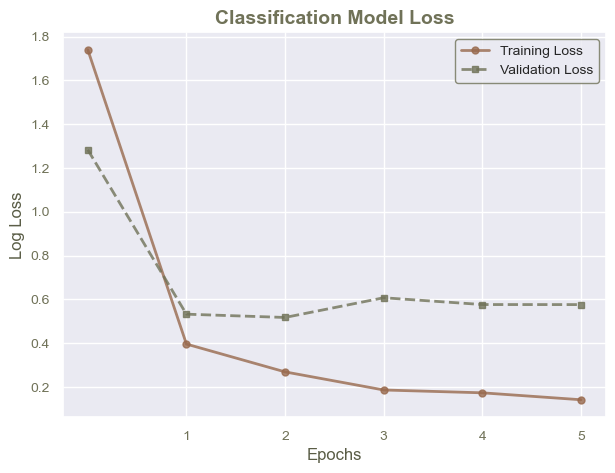

================ NUMBER OF PARAMETERS ================
How many parameters does model_RS have?
model_RS has 25691137 parameters

================ ACCURACY RESULTS ** AFTER ** TRAINING ================
Training Accuracy: 0.9062
Validation Accuracy: 0.8750

================ ACCURACY GAP ================
There is a 3.12% gap between training and validation accuracy.

================ GENERALIZABILITY ANALYSIS ================
Comment on model_RS accuracy on training vs. validation data:

The model demonstrates strong generalization capabilities because validation accuracy is very close to training accuracy.
This suggests that the model is effectively learning patterns that generalize well to unseen data.


In [20]:
# retrain the best model, plot its loss, and evaluate

# get the best model from the tuner
model_RS = RS_tuner.get_best_models(num_models=1)[0]

# # save it
# model_RS.save('model_RS.keras')
# # code to deploy it later
# from tensorflow.keras.models import load_model
# model_RS = load_model('best_model_RS.h5')

# retrain the best model to capture history
history = model_RS.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[early_stop_cb]
)

# look at best hyperparameters
hps_RS = RS_tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for key in hps_RS.values:
    print(f"{key}: {hps_RS.get(key)}")

# plot training and validation loss
plot_loss_pretty(history)

eval_accuracy(
        model_RS,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test=None,
        y_test=None,
        accuracy_threshold=0.05,
        model_name="model_RS"
)

### Hyperband Tuner for PDL

Starts training many models with fewer epochs, and only continues training the most promising ones.

In [21]:
# set up hyperband tuner
HB_tuner = Hyperband(
    hypermodel=build_model_tune_layers,   
    objective='val_accuracy',  # or 'val_auc' if we want to explore class imbalance later
    max_epochs=15, # upper limit for training duration
    factor=3,  # how aggressively to prune models; How aggressively underperforming models are stopped (3 = every round keeps ~1/3 of models)
    directory='hw10_tuning',
    project_name='Hyperband'
)

Reloading Tuner from hw10_tuning/Hyperband/tuner0.json


In [22]:
# run tuner
HB_tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[early_stop_cb] # same as before 
)

Trial 90 Complete [00h 00m 27s]
val_accuracy: 0.8125

Best val_accuracy So Far: 0.90625
Total elapsed time: 00h 54m 45s


Using optimizer: adam with learning rate: 0.00012192715180060102


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,381,377 (196.00 MB)

 Trainable params: 51,381,377 (196.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.8643 - loss: 0.2935 - val_accuracy: 0.7500 - val_loss: 0.5830
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 0.8750 - loss: 0.2541 - val_accuracy: 0.7812 - val_loss: 0.5507
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.9182 - loss: 0.2126 - val_accuracy: 0.9062 - val_loss: 0.6239
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.9276 - loss: 0.1922 - val_accuracy: 0.8750 - val_loss: 0.5995
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.9405 - loss: 0.1677 - val_accuracy: 0.7812 - val_loss: 0.5987
Best hyperparameters:
conv_1_filters: 32
conv_1_kernel: 3
dropout: 0.2
dense_units: 128
optimizer: adam
learning_rate: 0.00012192715180060102
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0056


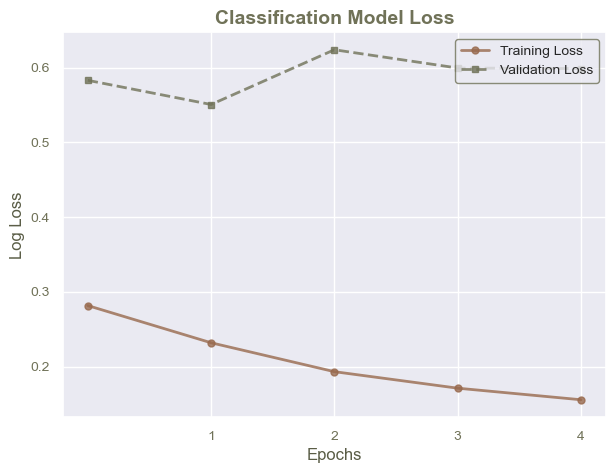

================ NUMBER OF PARAMETERS ================
How many parameters does model_HB have?
model_HB has 51381377 parameters

================ ACCURACY RESULTS ** AFTER ** TRAINING ================
Training Accuracy: 0.9010
Validation Accuracy: 0.7812

================ ACCURACY GAP ================
There is a 11.98% gap between training and validation accuracy.

================ GENERALIZABILITY ANALYSIS ================
Comment on model_HB accuracy on training vs. validation data:

The accuracy gap is larger than 5.0%, indicating that the model does not generalize well to new data.
Since the training accuracy is higher than the validation accuracy, the model is likely overfitting — 
memorizing noise and specific patterns in the training data rather than learning the underlying relationships 
that generalize well to new data.


In [23]:
# retrain the best model, plot its loss, and evaluate

# get the best model from the tuner
model_HB = HB_tuner.get_best_models(num_models=1)[0]

# retrain the best model to capture history
history_HB = model_HB.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[early_stop_cb]
)

# look at best hyperparameters
hps_HB = HB_tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for key in hps_HB.values:
    print(f"{key}: {hps_HB.get(key)}")

# plot training and validation loss
plot_loss_pretty(history_HB)

eval_accuracy(
        model_HB,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test=None,
        y_test=None,
        accuracy_threshold=0.05,
        model_name='model_HB'
)

## Tune Number of Layers (NL)

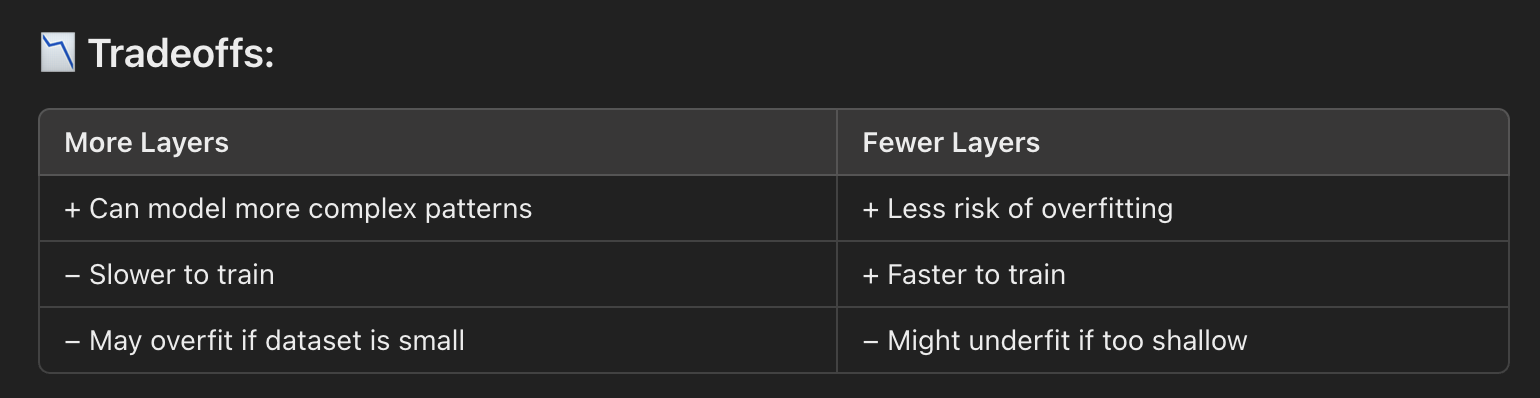

In [24]:
# build tunable model function that tunes NUMBER of layers
tf.random.set_seed(1234)
np.random.seed(1234)

def build_model_tune_num_layers(hp):
    '''Build a TF CNN model to tune number of layers
    and the hyperparameters within those layers.
    '''

    # initialize model
    model = tf.keras.Sequential()

    # input layer
    model.add(tf.keras.layers.Input(shape=(224, 224, 3)))

    # tune number of convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int(f'conv_{i}_filters', 32, 128, step=32),
            kernel_size=hp.Choice(f'conv_{i}_kernel', [3, 5]),
            activation='relu',
            padding='same'
        ))
        # add pooling layer after each conv layer
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    # add flattening layer
    model.add(tf.keras.layers.Flatten())

    # tune number of dense layers
    for j in range(hp.Int('num_dense_layers', 1, 2)):
        model.add(tf.keras.layers.Dense(
            #units=hp.Int(f'dense_{j}_units', 64, 128, step=32), # too intense for my RAM
            units= hp.Choice(f'dense_{j}_units', values=[32, 64]),# tells the layer how many neurons it should have
            activation='relu'
        ))
        # add dropout layer after each dense layer
        model.add(tf.keras.layers.Dropout(hp.Float(f'dropout_{j}', 0.2, 0.5, step=0.1)))

    # add classification layer
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # define optimizer choices
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd', 'adadelta']) # optimizer is how the model learns

    # tune learning rate for all optimizers
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    # build optimizer object based on the choice
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'adadelta':
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    else:  # 'sgd'
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # compile model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy', # loss function is what the model tries to minimize
        metrics=['accuracy'] # metric is how performance is evaluated
    )

    # print model_tf summary
    model.summary()

    # aaaaaand we keep crashing, hopefully this will help
    if model.count_params() > 25_000_000:
        raise ValueError("Too many parameters! Model rejected.")

    return model 

### RandomSearch Tuner for NL

In [25]:
# set up RandomSearch tuner

# initalize tuner
RSNL_tuner = RandomSearch(
    hypermodel=build_model_tune_num_layers,
    objective='val_accuracy', # could also try 'val_auc' in situations where class imbalance becomes an issue.
    max_trials=10, # number of hyperparam combinations to try; how many models to build and test
        # will probably need to increase from 10 to 20, 30, or 50
    executions_per_trial=1, # optional: how many times to train each model; 1 is default
        # 1 is default and faster; increase to 2–3 if we get high variance in accuracy between runs
    directory='hw10_tuning',
    project_name='RandomSearch_NL'
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │    12,845,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,846,017 (49.00 MB)

 Trainable params: 12,846,017 (49.00 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# run tuner
RSNL_tuner.search(
    X_train, y_train,
    epochs=30, # start with something reasonably high knowing early stopping can kick in
        # 30 might be too high if we see validation accuracy flattening after just 3–5 epochs, no earlystopping, or training takes too long
    validation_data=(X_val, y_val),
    callbacks=[early_stop_cb] # same as before
)

Trial 10 Complete [00h 00m 02s]

Best val_accuracy So Far: 0.8125
Total elapsed time: 00h 17m 35s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     3,211,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,257,953 (12.43 MB)

 Trainable params: 3,257,953 (12.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7749 - loss: 0.4169 - val_accuracy: 0.8125 - val_loss: 0.5194
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8182 - loss: 0.3822 - val_accuracy: 0.7812 - val_loss: 0.5397
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8375 - loss: 0.3831 - val_accuracy: 0.7812 - val_loss: 0.5628
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8397 - loss: 0.3889 - val_accuracy: 0.8125 - val_loss: 0.5814
Best hyperparameters:
num_conv_layers: 2
conv_0_filters: 128
conv_0_kernel: 5
num_dense_layers: 1
dense_0_units: 32
dropout_0: 0.30000000000000004
optimizer: adam
learning_rate: 0.0001051834478453516
conv_1_filters: 32
conv_1_kernel: 3


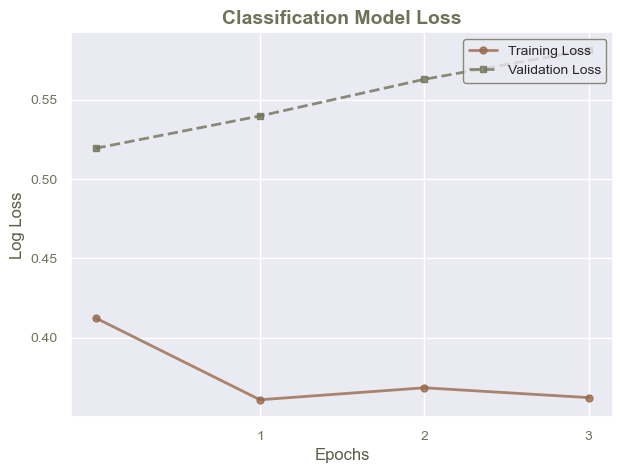

================ NUMBER OF PARAMETERS ================
How many parameters does model_RSNL have?
model_RSNL has 3257953 parameters

================ ACCURACY RESULTS ** AFTER ** TRAINING ================
Training Accuracy: 0.8542
Validation Accuracy: 0.8125

================ ACCURACY GAP ================
There is a 4.17% gap between training and validation accuracy.

================ GENERALIZABILITY ANALYSIS ================
Comment on model_RSNL accuracy on training vs. validation data:

The model demonstrates strong generalization capabilities because validation accuracy is very close to training accuracy.
This suggests that the model is effectively learning patterns that generalize well to unseen data.


In [27]:
# retrain the best model, plot its loss, and evaluate

# get the best model from the tuner
model_RSNL = RSNL_tuner.get_best_models(num_models=1)[0]

# save it
#model_RSNL.save('model_RSNL.keras')
# # code to deploy it later
# from tensorflow.keras.models import load_model
# model_RSNL = load_model('best_model_RS.h5')

# retrain the best model to capture history
history = model_RSNL.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stop_cb]
)

# look at best hyperparameters
hps_RSNL = RSNL_tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for key in hps_RSNL.values:
    print(f"{key}: {hps_RSNL.get(key)}")

# plot training and validation loss
plot_loss_pretty(history)

eval_accuracy(
        model_RSNL,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test=None,
        y_test=None,
        accuracy_threshold=0.05,
        model_name='model_RSNL'
)

### Hyperband Tuner for NL

In [28]:
# set up hyperband tuner
HBNL_tuner = Hyperband(
    hypermodel=build_model_tune_num_layers, 
    objective='val_accuracy',  # or 'val_auc' if we want to explore class imbalance later
    max_epochs=15, # upper limit for training duration
    factor=3,  # how aggressively to prune models; How aggressively underperforming models are stopped (3 = every round keeps ~1/3 of models)
    directory='hw10_tuning',
    project_name='Hyperband_NL'
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │    12,845,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,846,017 (49.00 MB)

 Trainable params: 12,846,017 (49.00 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# run tuner
HBNL_tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[early_stop_cb] # same as before 
)

Trial 25 Complete [00h 03m 13s]
val_accuracy: 0.71875

Best val_accuracy So Far: 0.875
Total elapsed time: 00h 09m 20s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │    12,845,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,848,609 (49.01 MB)

 Trainable params: 12,848,609 (49.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.6539 - loss: 0.6387 - val_accuracy: 0.7500 - val_loss: 0.5083
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.7994 - loss: 0.4929 - val_accuracy: 0.7500 - val_loss: 0.5228
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.7818 - loss: 0.4034 - val_accuracy: 0.8438 - val_loss: 0.5529
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.8215 - loss: 0.3530 - val_accuracy: 0.8750 - val_loss: 0.7181
Best hyperparameters:
num_conv_layers: 1
conv_0_filters: 32
conv_0_kernel: 5
num_dense_layers: 2
dense_0_units: 32
dropout_0: 0.30000000000000004
optimizer: adam
learning_rate: 0.0024056946471786023
conv_1_filters: 32
conv_1_kernel: 5
dense_1_units: 32
dropout_1: 0.30000000000000004
conv_2_filters: 128
conv_2_kernel: 3
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0


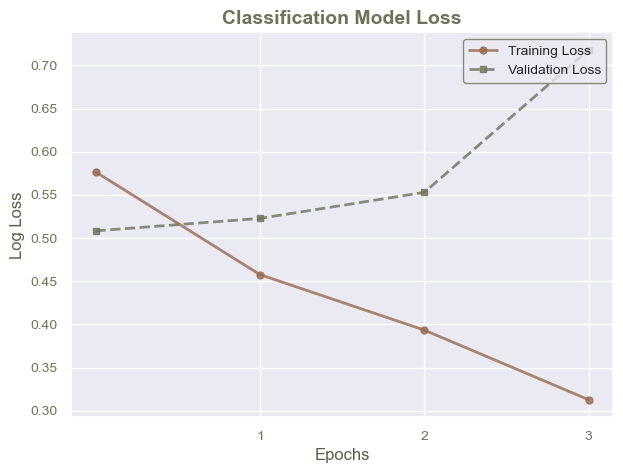

================ NUMBER OF PARAMETERS ================
How many parameters does model_HBNL have?
model_HBNL has 12848609 parameters

================ ACCURACY RESULTS ** AFTER ** TRAINING ================
Training Accuracy: 0.8594
Validation Accuracy: 0.7500

================ ACCURACY GAP ================
There is a 10.94% gap between training and validation accuracy.

================ GENERALIZABILITY ANALYSIS ================
Comment on model_HBNL accuracy on training vs. validation data:

The accuracy gap is larger than 5.0%, indicating that the model does not generalize well to new data.
Since the training accuracy is higher than the validation accuracy, the model is likely overfitting — 
memorizing noise and specific patterns in the training data rather than learning the underlying relationships 
that generalize well to new data.


In [30]:
# retrain the best model, plot its loss, and evaluate
# get the best model from the tuner
model_HBNL = HBNL_tuner.get_best_models(num_models=1)[0]

# retrain the best model to capture history
history_HBNL = model_HBNL.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[early_stop_cb]
)

# look at best hyperparameters
hps_HBNL = HBNL_tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for key in hps_HBNL.values:
    print(f"{key}: {hps_HBNL.get(key)}")

# plot training and validation loss
plot_loss_pretty(history_HBNL)

eval_accuracy(
        model_HBNL,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test=None,
        y_test=None,
        accuracy_threshold=0.05,
        model_name='model_HBNL'
)

In [32]:
# saving my models bc it is a freaking miracle that i only killed the kernel twice
model_RS.save('model_RS.keras')
model_HB.save('model_HB.keras')
model_RSNL.save('model_RSNL.keras')
model_HBNL.save('model_HBNL.keras')

In [ ]:
# # code to load models in case i need it later
# from tensorflow.keras.models import load_model

# model_RS = load_model('model_RS.keras')
# model_HB = load_model('model_HB.keras')
# model_RSNL = load_model('model_RSNL.keras')
# model_HBNL = load_model('model_HBNL.keras')

# Best Model

model_RS has the highest accuracy and the best generalizability, so I choose it as my final model. 

model_RS has 25,691,137 parameters.

The fine-tuned model (model_RS) is a huge improvement over the baseline model (model_tf), in both accuracy and generalizability.

The fine-tuned model increases validation accuracy by 50% while narrowing the accuracy gap between training and validation data by 12.5% - meaning the fine-tuned model also does a much better job of generalizing than the baseline model. 

---
### Step 7: Evaluation

Now we will use the test data to evaluate the performance (accuracy) of our fine-tuned model on unseen data and determine if it generalizes well.

In [ ]:
model_RS.evaluate(X_test, y_test)

In [33]:
eval_accuracy(
        model_RS,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test=X_test,
        y_test=y_test,
        accuracy_threshold=0.05,
        model_name='model_RS'
)

================ NUMBER OF PARAMETERS ================
How many parameters does model_RS have?
model_RS has 25691137 parameters

================ ACCURACY RESULTS ** AFTER ** TRAINING ================
Training Accuracy: 0.9062
Validation Accuracy: 0.8750
Test Accuracy: 0.8438

================ ACCURACY GAP ================
There is a 3.12% gap between training and validation accuracy.
There is a 6.25% gap between training and testing accuracy.

================ GENERALIZABILITY ANALYSIS ================
This gap is larger than 5.0%, indicating that the model does not generalize well to new data.
Since the training accuracy is higher than the test accuracy, the model is likely overfitting — 
memorizing noise and specific patterns in the training data rather than learning the underlying relationships 
that generalize well to new data.


The model isn't generalizing terribly, but also not as well as I had hoped. There is likely some overfitting happening. If I had more time, I would try to improve model performance by adding further augmentations to the dataset and experimenting with more keras tuner configurations. 